In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
sns.set_context('talk')
sns.set_style('whitegrid')
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
np.random.seed(1)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/walfits/anaconda3/envs/deffi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Kernel regression

In the post I'm going to introduce *Kernel* regression as a **precursor** to Gaussian Processes regression. To start with we'll review linear regression and then introduce a very simple extension using a limited number kernels, which we'll think of as just like multivariate regression. A complicated picture will arise when we let the number of kernels being used equal the number of data.  Finally we'll abandon ordinary least squares regression and show kernel regression proper as a way of averaging data.  

Last sentence is a bit unclear

## Linear regression uses the multivariate normal distribution

Our data are $N$ observations of a reponse and independent variable: $(y_i, X_i)\ i = 1, ..., N$. The $X_i$ could be vectors (for multivariate linear regression) **or** could be realisations of a single variable.  Initially we'll keep things simple and assume the latter.  

The main model assumptions are that each $y_i$ is normally distributed, with a mean given by a linear function of the dependent variable, $\mu_i = \beta_0 + \beta_1x_i$ (**should this be capital X?**) and a common variance, $\sigma^2$.  In other words: 

$$
\begin{align}
y_i \sim & \mathcal{N}(\mu, \sigma^2)\\
\sim & \mathcal{N}(\beta_0 + \beta_1X_i, \sigma^2)
\end{align}
$$


Our task is to estimate the $\beta$'s by minimizing the squared errors (alternatively maximimizing the log-likelihood) between the estimated mean values $\hat{\beta}_0 + \hat{\beta}_1 X_i$ the true values $y_i$ (the hats denote an estimated quantity). 

An example is shown below in graphical format. We're using the OLS (**What is OLS?**) model from the python module [`statsmodels`](https://www.statsmodels.org/stable/index.html).  Here the true values of the parameters are $\beta_0 = 2$ and $\beta_1 = 0.5$.  

In [2]:
x = np.linspace(-1,1,20)
y = 2 + 0.5*x + np.random.normal(0, 0.1, len(x))
df = pd.DataFrame({'x': x, 'y': y})
result = smf.ols('y ~ x', data=df).fit()

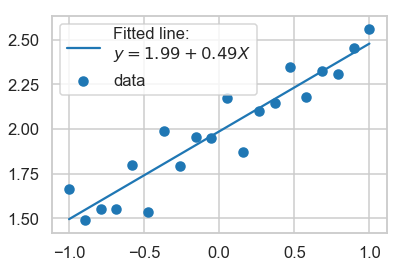

In [3]:
plt.scatter(x, y, label='data')
plt.plot(x, result.fittedvalues, 
         label='Fitted line:\n$y = {0:4.2f} + {1:4.2f}X$'.format(*result.params))
_ = plt.legend()

## If the data are non-linear we can add polynomial terms

If the data are non-linear in $X$ then we could add a $X^2$ term to the regression.  i.e. 
$$
Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon
$$

**Not sure if I have misunderstood what's going on, but maybe stick to the previous notation?**
$$
\begin{align}
y_i \sim & \mathcal{N}(\mu, \sigma^2)\\
\sim & \mathcal{N}(\beta_0 + \beta_1 X_i + \beta_2 X_i^2, \sigma^2)
\end{align}
$$

This is known as [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression). 

An example of this is shown below, where we've just added a $\beta_2 = -1$ term to the previous equation. 

In [4]:
x = np.linspace(-1,1,20)
y = 2 + 0.5*x - x**2 + np.random.normal(0, 0.1, len(x))
df = pd.DataFrame({'x': x, 'y': y})
result = smf.ols('y ~ x + np.power(x, 2)', data=df).fit()

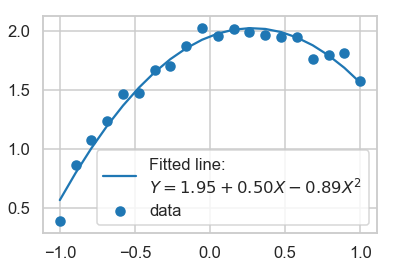

In [5]:
plt.scatter(x, y, label='data')
plt.plot(x, result.fittedvalues, 
         label='Fitted line:\n$Y = {0:4.2f} {1:+4.2f}X {2:+4.2f}X^2$'.format(*result.params))
_ = plt.legend()

The model is still a multivariate normal but the elements of the mean function are now no longer linearly increasing. Like the linear case the covariance matrix still has no off-diagonal non-zero elements. 
**Not sure what this sentence meant**

We could extend this to any number of cubic, quartic etc. terms.  In other words, we would be using a polynomial basis to fit the non-linear relationship between X and Y. The problem with this is that the value of $y$ at $X= -1$ is dependent on the value of $Y$ at $X = 1$.  i.e. a polynomial basis is *non-local*.  
**Is the capital and non-capital _y_ intended?**

To avoid the problem of non-locality we can use a series of *kernels* instead of a the polynomial terms.  


## Kernels also allow non-linearities
A [kernel][1] is a symmetric function that takes two inputs and returns a single, positive output. A kernel measures the similarity between the two inputs.
A popular kernel is the *Gaussian* kernel, which is shown below: 

$$
K(x, x') = \exp\left(-\frac{||x - x'||^2}{w}\right)
$$

$w$ is known as the bandwidth.  This measures the similarity between two points $x$ and $x'$.  
[1]: https://en.wikipedia.org/wiki/Kernel_(statistics)#Nonparametric_statistics


In **Kernel** regression we replace the powers of $X$ in polynomial regression with the values of the kernel at different values of $X$. These values are known as **knots** or **centroids** which we'll label $q$ to highlight the fact they are logically distinct from the covarite $X$. The equation below has three centroids ($q_1,q_2,q_3$): 

$$
y_i = \gamma_1 K(X_i, q_1) + \gamma_2 K(X_i, q_2) + \gamma_3 K(X_i, q_3) + \epsilon
$$

**Maybe specify that K(X_i, q_1) is the value of the first kernel at X_i? And that q1 refers to x' in the equation before?** 

To estimate the parameters, $\gamma$, we can (kind of) still use all the machinery of OLS regression. To demonstrate let's use some highly non-linear data, a **noisy** sine curve:  

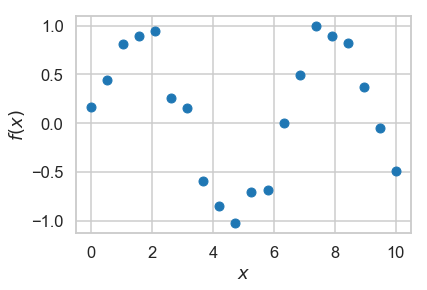

In [7]:
np.random.seed(1)
N = 20
x = np.linspace(0, 10, N)
ytrue = np.sin
y = ytrue(x) + np.random.normal(0,0.1, size=N)
with sns.plotting_context('talk', font_scale=1):
    plt.plot(x, y, 'o')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')

 Let's have 5 knots equally spaced across the $X$ axis each with a bandwidth of 2:
 
 **Do you need to norm the thing below?**

In [8]:
def gauss_kernel(x, knots, w=2):
    # Gaussian kernel using predetermined knots. 
    unnormed = [np.exp(-(x-knot)**2/w) for knot in knots]
    normed = unnormed #[x/x.sum() for x in unnormed]
    return np.array(normed).T

In [9]:
n_knots = 5
knots = np.linspace(np.floor(x.min()), np.ceil(x.max()), n_knots)
w = 2
K = gauss_kernel(x, knots, w=w) 

The variable `K` is a matrix of dimension $N \times 5$.  You can think of it as a design matrix like multivariate linear regression where each column is a different variable.  

For each knot, there is a kernel defined over all the data. i.e. for each knot, there's a value of $K$ for each value of $X$.  Let's plot this: 

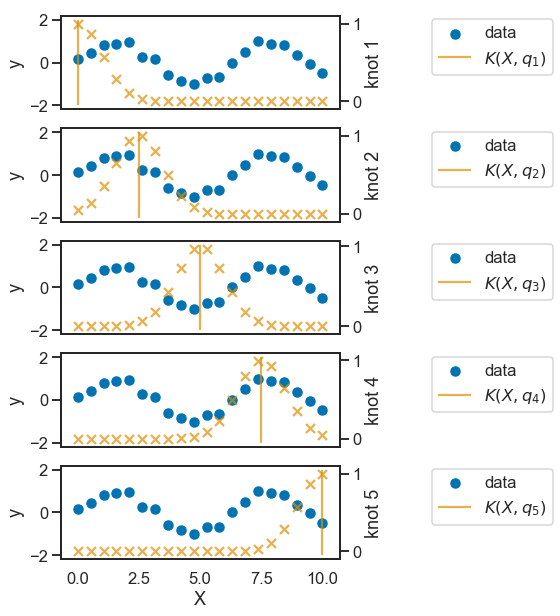

In [10]:
with sns.plotting_context('talk'):
    sns.set_style('white')
    fig, axes = plt.subplots(n_knots, figsize=(5,10), 
                             sharex=True, sharey=True)
    cols = sns.color_palette('colorblind')
    
    for i, ax in enumerate(axes):
        
        ax.scatter(x, y, color=cols[0], marker='o', label='data')
        ax2 = ax.twinx()
        
        ax2.scatter(x, K.T[i], color=cols[1], alpha=0.7, marker='x')
        ax.vlines(knots[i], -2, 2, color=cols[1], alpha=0.7, 
                  label=r'$K(X, q_{%s} )$' %  str(i+1))
        ax.legend(bbox_to_anchor=(1.3, 1.05))
        ax2.set_ylabel('knot %s' % str(i+1))
        ax.set_ylabel('y')
    ax.set_xlabel('X')


## Kernel regression is local
As you can see, the  x's look like Gaussian's (because they are) around the knot center (the vertical line).  The value of $K$ is non-zero only for a small number of data points around the knot center. 

So why do this?  

Well, it allows us to assign a regression coefficient to a small subset of the data points - those that are similar or *local* to the knots.  For example, those data far the first knot, i.e.  $ |x - q_1|^2 \gg w$ the value of  $K \simeq 0$.  This means, the only terms in the regression equation are those near $q_1$.  i.e.: 

$$
\hat{Y} \approx \gamma_1 K(X, q_1) = \gamma_1 \exp\left(-\frac{||X-q_1||^2}{w}\right)
$$

(From now on I'll drop write $K(X, q_1)$ as $K_1(X)$ to save space on the figures.)

The predicted value of the  response variable approaches $\gamma_1$ as the values of the input variables approach the first knot, $q_1$ from either side. 

For values of $X$ that fall inbetween $q_1$ and $q_2$, the predicted value of the response variable will  be a weighted average of predominately $\gamma_1$ and $\gamma_2$.  The weights will be the values of $K_1(X)$ and $K_2(X)$. 

*So Kernel regression makes predictions at $X$ based on the average of those regression coefficients, $\gamma$, in the neighbourhood of $X$.*

## Conditioning a kernel regression model

To find the coefficients let's just use the OLS model and treat each $K_i$ as a different independent variables. This means we **are** conditioning the model just like multivariate linear regression. So $K$ is a $N\times 5$ matrix, where the $K_{ij}$ element is the value $K_{j}(X_i)$. 

In [11]:
model = sm.OLS(y, K)
result = model.fit()

Let's plot the data and the prediction.  To make the prediction curve nice and smooth, we've created a new vector of X values, very tightly spaced. 

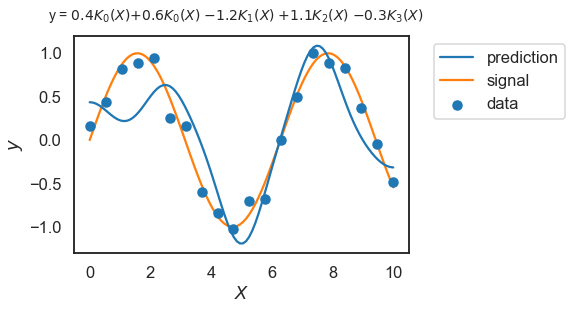

In [12]:
Xnew = np.linspace(x.min(), x.max(), 100)
Knew = gauss_kernel(Xnew, knots, w=1)
y_predict = result.predict(Knew)

linelabel = ' '.join([r'$ %+4.1f K_{%s}(X)$' % (x,i) for i, x in enumerate(result.params[1:])])
linelabel = 'y = '+' '.join([r'$ %4.1f K_{%s}(X)$' % (x,i) for i, x in enumerate(result.params[:1])]) + linelabel

plt.scatter(x, y, label='data')
plt.plot(Xnew, y_predict, label='prediction')
plt.plot(Xnew, ytrue(Xnew), label='signal', zorder=0)
plt.xlabel("$X$"); plt.ylabel("$y$")
plt.legend(bbox_to_anchor=(1.05, 1))
_ = plt.suptitle(linelabel, fontsize=14)


## Using more knots comes at a price

The fit isn't great - it *kind of* gets the shape but misses the amplitude badly. How could we improve the fit? 

Well, in our model we have arbitrarily set three parameters: 
1. The number of knots
2. The location of the knots
3. The bandwidth

One approach to improve our fit would be to use cross validation to select these parameters, but that seems difficult with the location of the knots. 

It makes sense that more knots would increase the flexibility of the basis, so why not just use *the data as the knot points*.   

The regression equation will be then: 

$$
y(X) = \sum \gamma_i K(X, q_i = X_i) + \epsilon
$$

Observe that there are now as many parameters as data points.  This fact is what makes this a [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) regression method. 


Let's run the regression in the same way as before. We'll call this new $K$ matrix `Kx` to highlight the fact that the knots are centered at values of $X$. 

In [13]:
bw = 2
Kx = gauss_kernel(x, knots=x, w=bw)
Kx.shape

(20, 20)

So now `Kx` is an $N\times N$ instead of $N\times 5$ matrix.  

In [14]:
model = sm.OLS(y, Kx)
result = model.fit()

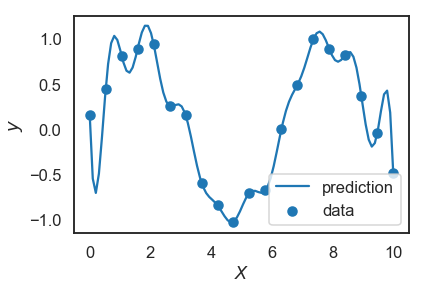

In [15]:
Xnew = np.linspace(x.min(), x.max(), 100)
Knew = gauss_kernel(Xnew, x, w=bw) 
y_predict = result.predict(Knew)

plt.scatter(x, y, label='data')
plt.plot(Xnew, y_predict, label='prediction')
plt.xlabel("$X$"); plt.ylabel("$y$")
_ = plt.legend()


Let's disect this. 

**The good**: the regression line goes through the data!  But that's only to be expected - we have as many parameters ($\gamma$s) as data points. 

**The bad**  We've totally [overfit](https://en.wikipedia.org/wiki/Overfitting) our model. At the moment it just looks like we could have linearly interpolated and done as good a job.  

Nevertheless it does seem like the fit is better compared to 5 knots so let's investigate the model a bit more carefully.  What can the fitted values of $\gamma_i$ reveal?

Let's look at the summary of the fit. 



In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Thu, 30 Aug 2018   Prob (F-statistic):                nan
Time:                        20:46:58   Log-Likelihood:                 456.22
No. Observations:                  20   AIC:                            -872.4
Df Residuals:                       0   BIC:                            -852.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1255.3516        inf          0        nan         nan         nan
x2         -5673.7457        inf         -0        nan         nan         nan
x3          1.441e+04        inf          0        nan         nan         nan
x4         -2.722e+04        inf         -0        nan         nan         nan
x5          4.267e+04        inf          0        nan         nan         nan
x6         -5.875e+04        inf         -0        nan         nan         nan
x7           7.35e+04        inf          0        nan         nan         nan
x8         -8.535e+04        inf         -0        nan         nan         nan
x9          9.324e+04        inf          0        nan         nan         nan
x10         -9.66e+04        inf         -0        nan         nan         nan
x11         9.527e+04        inf          0        nan         nan         nan
x12        -8.945e+04        inf         -0        nan         nan         nan
x13         7.968e+04        inf          0        nan         nan         nan
x14        -6.685e+04        inf         -0        nan         nan         nan
x15         5.216e+04        inf          0        nan         nan         nan
x16        -3.708e+04        inf         -0        nan         nan         nan
x17         2.324e+04        inf          0        nan         nan         nan
x18        -1.213e+04        inf         -0        nan         nan         nan
x19         4721.1359        inf          0        nan         nan         nan
x20        -1036.8394        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                        5.902   Durbin-Watson:                   0.610
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                3.933
Skew:                           1.064   Prob(JB):                        0.140
Kurtosis:                       3.436   Cond. No.                     3.70e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.54e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Oh dear.  The $\gamma$s are huge and their standard errors are infinite.  We also have a warning about *strong  [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)*.  That is indeed our problem - let's just look at two of the $K_i$ plotted against each other. 



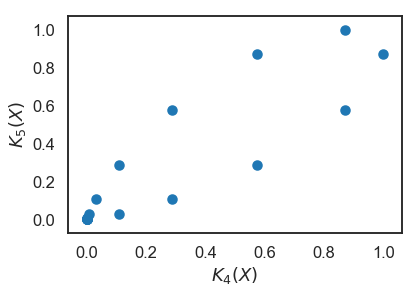

In [51]:
i, j = 4, 5
plt.scatter(Kx[:,i], Kx[:,j])
plt.xlabel(r'$K_{% d}(X)$' % i); _ = plt.ylabel(r'$K_{% d}(X)$' % j)

We can even drop in to see what [condition](https://en.wikipedia.org/wiki/Condition_number) our matrix is in: 


In [52]:
np.linalg.cond(Kx)

3704592.808511907

So clearly we have a problem.  Let's try to figure out what the $\gamma$s *should* be and see if we can fix it.  

We've already said the value of $K_i(X)$ gives the weight of $\gamma_i$ in the sum predicting $y$:

$$
\hat{y}(X) = \sum \gamma_i K(X, q_i = X_i)
$$

If the weights all summed to one at any particular $X$ then it would make sense to have $\gamma_i = y_i$ because then our prediction would be a weighted average of the nearby values of our response which seems reasonable.  Well, we can do this simply dividing each $K_i(X)$ by the sum of all kernels at $X$:
$$
\hat{y}(X_i) = \sum_j y_j \frac{K(X_i, q_j = X_j)}{\sum_k K(X_i, q_k = X_k)}
$$

Or in matrix notation: 

$$
\hat{y}(X) = W\cdot y
$$

where

$$
W_{ij} = \frac{K(X_i, q_j = X_j)}{\sum_k K(X_i, q_k = X_l)}
$$


Now we can abandon OLS regression all together and just use this analytic expression to make predictions. Let's do this now, using the same bandwidth as before. The knot points are the values of $X_i$ and our coefficients $\gamma_i$ are the response $y_i$. We'll create a dense grid on $X$ to get a nice smooth prediction as we've done before. 

In [17]:
def kregression(x, y, knots, bw=2):
    # Get kernel
    Kx = gauss_kernel(x, knots=knots, w=bw)
    Kx_norm = Kx/Kx.sum(axis=1)[:, np.newaxis]

    # Prediction
    y_predict = np.dot(Kx_norm, y)
    return y_predict

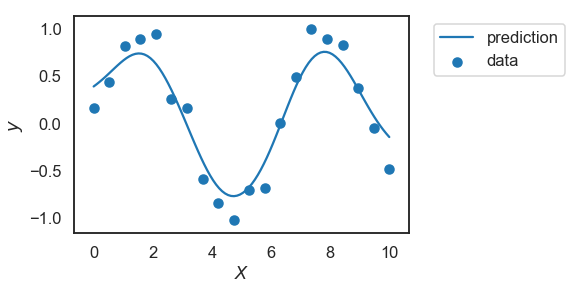

In [18]:
Xnew = np.linspace(x.min(), x.max(), 100)
y_predict = kregression(x=Xnew, y=y, knots=x, bw=1)

plt.plot(Xnew, y_predict, label='prediction')
plt.scatter(x, y, label='data')
plt.xlabel("$X$"); plt.ylabel("$y$")
_ = plt.legend(bbox_to_anchor=(1.05, 1))


Great! Now we're getting somewhere.  In fact, we have arrived exactly at [Nadaraya–Watson kernel regression](https://en.wikipedia.org/wiki/Kernel_regression).  So we have rid oursevelves of:
* OLS regression and the regression parameters,
* the need to decide how many knots,
* and where to place them.  

All we have to tackle now is the bandwidth parameter. 

## The bandwidth controls the smoothness
Let's see what happens when we change the bandwith by an arbitrary factor of 10 each way.  

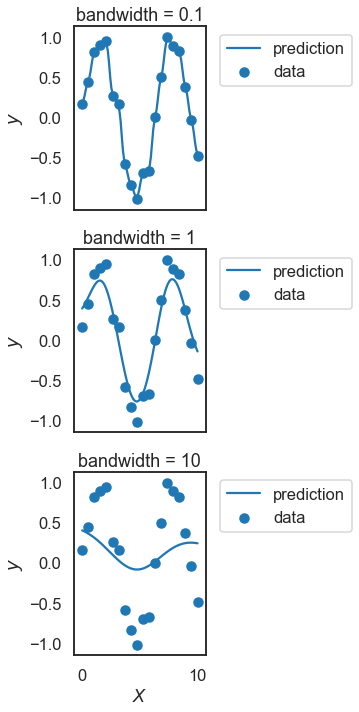

In [19]:
bandwidths = [0.1, 1, 10]
Xnew = np.linspace(x.min(), x.max(), 100)

fig, axes  = plt.subplots(len(bandwidths), figsize=(5,10), sharex=True)

for i, bw in enumerate(bandwidths): 
    ax = axes[i]
    

    y_predict = kregression(x=Xnew, y=y, knots=x, bw=bw)

    # plot
    ax.scatter(x, y, label='data')
    ax.plot(Xnew, y_predict, label='prediction')
    ax.set_ylabel("$y$")
    ax.set_title('bandwidth = {}'.format(bw))
    ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_xlabel("$X$");    
plt.tight_layout()

So if the bandwidth is too small then we overfit to our data, if it's too large then we don't reproduce the patter - the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

Why is this?  First, let's remember that the value of the predicted response, $\hat{y}$ at any arbitrary point $X=x'$ is the weighted average of ALL the $y_i$. The weights (given by the values of the all the kernels at $x'$) measure the similarity of $x_i$ to $x'$.  The more similar $x_i$ is to $x'$ the more heavily the value of $y_i$ weighs in the prediction.  

As you can see below, as the bandwidth increases the range of $X$ over which the kernel is non-zero increases.  

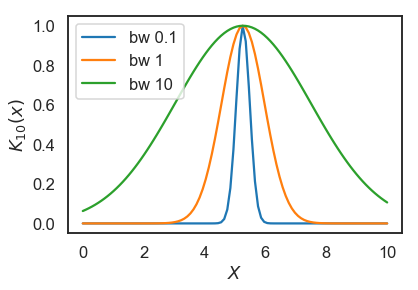

In [20]:
for bw in bandwidths: 
    plt.plot(Xnew, gauss_kernel(Xnew, knots=x, w=bw).T[10], label='bw {}'.format(bw))
plt.xlabel("$X$"); plt.ylabel("$K_{10}(x)$")
_ = plt.legend()

So let's plot ALL the kernels and zoom in on the region around $X = \pi/2$ (the first top of the curve) for the low bandwidth first. 

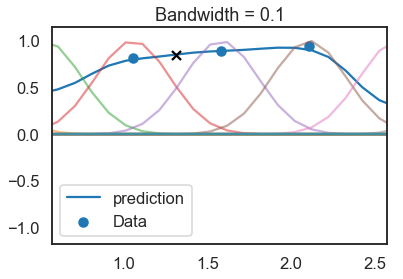

In [21]:
Xnew = np.linspace(x.min(), x.max(), 100)

bw = bandwidths[0]

y_predict = kregression(x=Xnew, y=y, knots=x, bw=bw)

#plot
plt.plot(Xnew, y_predict, label='prediction')
for i in range(len(x)):
    plt.plot(Xnew, gauss_kernel(Xnew, knots=x, w=bw).T[i], alpha=0.5)
plt.scatter(x, y, label='Data')
plt.scatter(Xnew[13], y_predict[13], marker='x', color='k', zorder=2+len(x))
plt.xlim(np.pi/2-1, np.pi/2+1)
plt.title('Bandwidth = {}'.format(bw))
_ = plt.legend()


Take the point marked with a black 'x'.  The kernels significantly greater than zero at that point are from the neighbouring two data points.  Essentially the predicted value is an interpolation of just the two neighbouring $y$ values.

Now let's look at the high bandwidth case. 

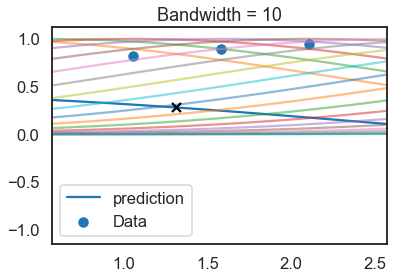

In [22]:
Xnew = np.linspace(x.min(), x.max(), 100)

bw = bandwidths[-1]
y_predict = kregression(x=Xnew, y=y, knots=x, bw=bw)

plt.scatter(Xnew[13], y_predict[13], marker='x', color='k', zorder=2+len(x))
plt.plot(Xnew, y_predict, label='prediction')
for i in range(len(x)):
    plt.plot(Xnew, gauss_kernel(Xnew, knots=x, w=bw).T[i], alpha=0.5)
plt.scatter(x, y, label='Data')
plt.xlim(np.pi/2-1, np.pi/2+1)
plt.title('Bandwidth = {}'.format(bw))
_ = plt.legend()


Here we can clearly see that many more of the kernel values are non-zero at the point marked 'x'.  This means the prediction takes into account many more $\gamma$'s, albeit those further away from 'x' are weighted less. The change in $\hat{y}$ as we traverse the $X$ axis will **therefore** be slower. 

So clearly the bandwidth has an essential role to play in Kernel regression. How should be select it? A single parameter like this is really ammenable to selection through [cross-validation][1], but we won't pursue that here. 
[1]:https://en.wikipedia.org/wiki/Cross-validation_(statistics)

## Summary

We've seen that in order to regress non-linear data we can add polynomial terms to simple linear regression. Essentially we are creating new input variables ($X^2$ etc.) to create flexibility in our regressions.  We can take this further and replace the polynomial terms with functions of $X$ called *kernels*.  These kernels measure the similarity of the input variables to arbitrary points (knots) in the input variable space.  This technique works by taking weighted averages of regression coefficients.  The closer a data point is to a knot, the more the predicted value resembles the regression coefficient at that knot. With a few knots we get an OK fit to highly non-linear data. 

However if we make the knots equal to the data points themselves, our ordinary least squares regression technique breaks down because of multi-collinearity.  Instead we replace the regression coefficients with the values of the observed response variable ($y$).  A prediction at $x'$ is now a weighted average of $y_i$'s whose corresponsding $X_i$ values are similar to $x'$.  The bias-variance tradeoff is controlled by the bandwidth of the kernel which can be chosen by cross-validation. 